# MS019 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS019'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 138 x 1088000 (2125.0 s), ~1.12 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1088000 (2125.0 s), ~8.4 MB, data loaded>

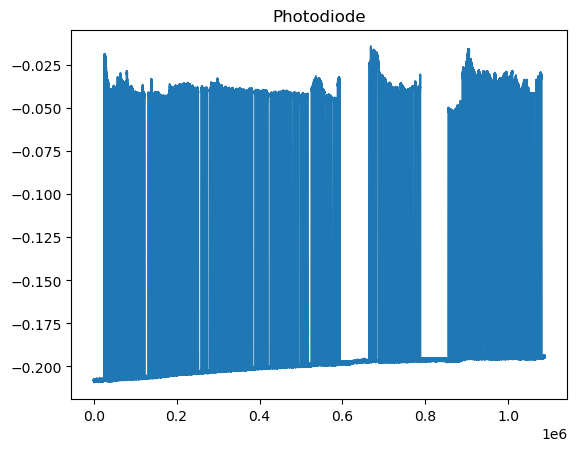

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-2.795636,34.346371,5.999996,-2.570422,27.802347,-5.413951,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9l_L,-11.581916,56.312073,43.999994,-12.306464,60.493542,33.029109,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 1 D,NaN,NaN
2,LaCaS11,Unknown,-12.380669,59.107707,48.399994,-13.320612,64.809729,37.490489,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-13.179422,60.305837,51.199993,-14.276922,66.898697,40.415833,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-3.594388,36.742630,9.999996,-3.429509,31.395072,-1.489375,Gray,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RsPpC7,A7ip_R,25.160712,-45.129531,35.999994,26.390526,-50.717179,46.775628,Gray,Right SPL superior parietal lobule,Unknown,Unknown,R SPL,Right superior parietal 2 D,WM,NaN
168,RsPpC8,A7ip_R,28.755099,-47.525789,39.199994,30.549717,-52.507090,50.966902,Gray,Right SPL superior parietal lobule,Area hIP3 (IPS),R Inferior Parietal Lobule,R SPL,Right superior parietal 2 D,NaN,NaN
169,RsPpC9,A7ip_R,32.349487,-49.522671,41.999994,34.673166,-54.045856,54.610691,Gray,Right SPL superior parietal lobule,Area hIP3 (IPS),R Inferior Parietal Lobule,R SPL,Right superior parietal 2 D,NaN,NaN
170,uLmOIF,A13_L,-4.792518,37.940759,-4.800003,-4.177642,28.423886,-18.311256,Gray,Left MFC medial frontal cortex,Area s32,L Rectal Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,46.0,mix,166.906253,166.919553,169.226881,171.243757,2.307328,0.0,-1.10,...,-0.000557,0.997523,0.002477,0.000557,0.000000,0.885201,0.000000,0.000000,0.885758,0.885201
1,2,101.0,loss,175.808985,175.817546,180.104779,182.121601,4.287233,-0.2,-0.34,...,-0.000146,0.500023,0.499977,0.000000,-0.000146,0.000013,-0.000146,0.000013,0.000000,0.000000
2,3,140.0,loss,187.642181,187.643002,190.399471,192.415833,2.756468,-0.5,-2.50,...,-0.001422,0.498359,0.501641,0.000000,-0.001422,-0.000968,-0.001422,-0.000968,0.000000,0.000000
3,4,35.0,mix,204.841573,204.849139,207.922985,209.939695,3.073846,0.0,-0.30,...,-0.000127,0.741975,0.258025,0.000127,0.000000,0.155908,0.000000,0.000000,0.156035,0.155908
4,5,114.0,loss,214.696737,214.704561,219.116613,219.122804,4.412052,-0.3,-0.67,...,-0.000317,0.499893,0.500107,0.000000,-0.000253,-0.000253,-0.000253,-0.000253,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,143.0,loss,2112.435856,2112.436581,2114.579035,2116.595655,2.142454,-0.6,-1.20,...,-0.000616,0.499903,0.500097,0.000616,0.000000,0.000558,0.000000,0.000000,0.000616,0.000558
146,147,95.0,gain,2121.587093,2121.595276,2123.574190,2125.590179,1.978914,0.6,0.00,...,0.000000,0.825863,0.174137,-0.787978,-0.787978,-0.558405,-0.787978,-0.558405,0.000000,0.000000
147,148,70.0,gain,2138.749941,2138.756112,2141.098827,2143.115514,2.342715,0.3,0.00,...,0.000000,0.975070,0.024930,-0.794013,-0.794013,-0.253269,-0.794013,-0.253269,0.000000,0.000000
148,149,97.0,gain,2147.662038,2147.667898,2150.010739,2152.027454,2.342841,0.6,0.00,...,0.000000,0.963162,0.036838,-1.039749,-1.039749,-0.558405,-1.039749,-0.558405,0.000000,0.000000


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [12]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 120 of 156 pulses


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 18626 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 20700 out of 20700 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 19940 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 20700 out of 20700 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 task

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~121.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~202.4 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,rmoif2,rmoif3,rmoif4,rmoif5,rmoif6,lacas11,lacas12,racas1,racas2,racas3,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.275,1.375,0.00,1.65,0.00,0.00,2.75,1.65,0.884643,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.170,-0.170,-0.34,-0.14,-0.34,-0.14,0.00,0.00,-0.000146,-0.000159
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.250,-1.250,-2.50,-2.00,-2.50,-2.00,0.00,0.00,-0.001422,-0.000454
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.030,0.330,0.00,0.36,0.00,0.00,0.66,0.36,0.155782,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,-0.30,-0.30,0.00,0.00,-0.000317,-0.000253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.600,0.600,0.00,0.60,0.00,0.00,1.20,0.60,-0.000616,-0.000558
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.745,-0.745,-1.49,-0.60,-1.49,-0.60,0.00,0.00,0.787978,0.558405
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750,-0.750,-1.50,-0.30,-1.50,-0.30,0.00,0.00,0.794013,0.253269
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.950,-0.950,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.039749,0.558405


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)